In [49]:

from tools2.config2 import BASE_DIR
import os
model_dir = os.path.join(BASE_DIR, 'models', 'new8')

In [ ]:
import os
import logging
from tools2.config2 import CONFIG, DATA_FILES, device, cuda_manager
from tools2.classes2 import SleepDataManager, NightBasedCrossValidator, EnsembleModel
from tools2.functions2 import *
from tools2.utils2 import (
    format_metrics_table, log_epoch_metrics, log_confusion_matrix,
    log_class_distribution, log_training_start, early_stopping_check,
    log_fold_results, calculate_metrics
)
from datetime import datetime
from collections import defaultdict


def setup_logging():
    """Setup logging configuration"""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    log_dir = os.path.join(CONFIG['model_dir'], 'logs')
    os.makedirs(log_dir, exist_ok=True)
    
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(os.path.join(log_dir, f'training_{timestamp}.log')),
            logging.StreamHandler()
        ]
    )

def get_training_parameters(data_manager):
    """Get training parameters based on configuration mode"""
    if CONFIG['training_mode']['hyperparameter_tuning']:
        logging.info("Starting hyperparameter tuning...")
        # Create a small validation set for tuning
        train_idx, val_idx = data_manager.create_cross_validator(n_splits=1).split(data_manager.data['y'])[0]
        
        # Get tuned parameters
        best_params = run_hyperparameter_tuning(
            X=data_manager.data['x'][train_idx],
            X_spectral=data_manager.data['x_spectral'][train_idx],
            y=data_manager.data['y'][train_idx],
            device=device,
            start_with_config=True  # Start from CONFIG values
        )
        
        model_params = {k: v for k, v in best_params.items() 
                       if k in ['n_filters', 'lstm_hidden', 'lstm_layers', 'dropout']}
        train_params = {
            'lr': best_params['lr'],
            'batch_size': best_params['batch_size'],
            'num_epochs': CONFIG['train_params']['initial']['num_epochs'],
            'patience': CONFIG['train_params']['initial']['patience']
        }
        
    else:
        logging.info("Using parameters from CONFIG...")
        model_params = CONFIG['model_params']['initial']
        train_params = CONFIG['train_params']['initial']
        
        # Optionally find best learning rate
        if CONFIG['training_mode']['find_lr']:
            logging.info("Finding optimal learning rate...")
            train_idx, val_idx = data_manager.create_cross_validator(n_splits=1).split(data_manager.data['y'])[0]
            
            # Initialize temporary model for LR finding
            temp_model, _ = initialize_model_with_gpu_check(model_params, device)
            temp_optimizer = optim.AdamW(temp_model.parameters(), 
                                       lr=train_params['lr'], 
                                       weight_decay=1e-5)
            
            # Create temporary loaders
            train_loader = data_manager.get_loader(train_idx, 
                                                 batch_size=train_params['batch_size'], 
                                                 is_training=True)
            val_loader = data_manager.get_loader(val_idx, 
                                               batch_size=train_params['batch_size'], 
                                               is_training=False)
            
            criterion = nn.CrossEntropyLoss(
                weight=data_manager.class_weights.to(device),
                label_smoothing=0.1
            )
            
            best_lr = find_lr(
                temp_model, train_loader, val_loader,
                temp_optimizer, criterion, device,
                start_lr=train_params['lr']
            )
            
            train_params['lr'] = best_lr
            logging.info(f"Found optimal learning rate: {best_lr:.2e}")
            
            # Clean up
            del temp_model
            torch.cuda.empty_cache()
    
    logging.info("Training parameters:")
    logging.info(f"Model parameters: {model_params}")
    logging.info(f"Training parameters: {train_params}")
    
    return model_params, train_params

def train_with_cv(data_manager, cv, model_params, train_params):
    """Train model using cross-validation"""
    results = []
    
    # Get splits while maintaining class distribution
    logging.info("Creating cross-validation splits...")
    splits = cv.split(data_manager.data['y'])
    
    # Check if splits are being created
    splits = list(splits)  # Convert generator to list
    logging.info(f"Number of splits created: {len(splits)}")
    
    if not splits:
        logging.error("No valid splits were created!")
        return results

    for fold, (train_idx, val_idx) in enumerate(splits, 1):
        logging.info(f"\nTraining Fold {fold}")
        logging.info(f"Train set size: {len(train_idx)}, Validation set size: {len(val_idx)}")
        
        # Create data loaders
        train_loader = data_manager.get_loader(
            train_idx,
            batch_size=train_params['batch_size'],
            is_training=True
        )
        
        val_loader = data_manager.get_loader(
            val_idx,
            batch_size=train_params['batch_size'],
            is_training=False
        )
        
        # Initialize model
        global device
        model, device = initialize_model_with_gpu_check(model_params, device)
        logging.info(f"Model initialized on {device}")
        
        # Setup training components
        optimizer = optim.AdamW(
            model.parameters(),
            lr=train_params['lr'],
            weight_decay=1e-5
        )
        
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )
        
        criterion = nn.CrossEntropyLoss(
            weight=data_manager.class_weights.to(device),
            label_smoothing=0.1
        )
        
        # Train fold
        best_model_state, metrics = train_fold(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            criterion=criterion,
            train_params=train_params,
            fold=fold
        )
        
        results.append({
            'fold': fold,
            'best_model_state': best_model_state,
            'metrics': metrics
        })
        
        # Log fold results
        log_fold_results(fold, metrics)
    
    return results

def train_fold(model, train_loader, val_loader, optimizer, scheduler, criterion, train_params, fold):
    """Train a single fold"""
    early_stopping = EarlyStoppingWithMetrics(
        patience=train_params['patience'],
        min_epochs=train_params.get('min_epochs', 20),
        min_delta=train_params.get('min_delta', 0.001)
    )
    
    best_metrics = None
    
    for epoch in range(train_params['num_epochs']):
        # Training phase
        train_metrics = train_epoch(
            model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            criterion=criterion
        )
        
        # Validation phase
        val_metrics = validate_epoch(
            model=model,
            val_loader=val_loader,
            criterion=criterion
        )
        
        # Update learning rate
        scheduler.step(val_metrics['loss'])
        
        # Log progress
        log_epoch_metrics(
            epoch=epoch,
            total_epochs=train_params['num_epochs'],
            train_metrics=train_metrics,
            val_metrics=val_metrics,
            current_lr=optimizer.param_groups[0]['lr']
        )
        
        # Early stopping check
        if early_stopping(val_metrics, model.state_dict(), epoch):
            logging.info(f"Early stopping triggered at epoch {epoch+1}")
            break
        
        # Update best metrics
        if best_metrics is None or val_metrics['f1_macro'] > best_metrics['f1_macro']:
            best_metrics = val_metrics
    
    # Log fold results
    log_fold_results(fold, best_metrics)
    
    return early_stopping.best_state, best_metrics

def train_epoch(model, train_loader, optimizer, criterion):
    """Train for one epoch"""
    model.train()
    metrics = defaultdict(float)
    all_predictions = []
    all_targets = []
    
    for batch_x, batch_x_spectral, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_x_spectral = batch_x_spectral.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x, batch_x_spectral)
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        metrics['loss'] += loss.item()
        predictions = outputs.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())
    
    # Calculate epoch metrics
    metrics['loss'] /= len(train_loader)
    metrics.update(calculate_metrics(all_predictions, all_targets))
    
    return metrics

def validate_epoch(model, val_loader, criterion):
    """Validate for one epoch"""
    model.eval()
    metrics = defaultdict(float)
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_x, batch_x_spectral, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_x_spectral = batch_x_spectral.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_x, batch_x_spectral)
            loss = criterion(outputs, batch_y)
            
            metrics['loss'] += loss.item()
            predictions = outputs.argmax(dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    
    metrics['loss'] /= len(val_loader)
    metrics.update(calculate_metrics(all_predictions, all_targets))
    
    return metrics

def convert_to_serializable(obj):
    """Convert objects to JSON serializable format"""
    if isinstance(obj, (np.ndarray, torch.Tensor)):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, Counter):
        return dict(obj)
    elif isinstance(obj, pd.DataFrame):
        return obj.to_dict(orient='records')
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_to_serializable(item) for item in obj)
    return obj

def save_best_model_results(results, data_manager, model_params, train_params, save_dir=model_dir):
    """Save only the best model and its results"""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    os.makedirs(save_dir, exist_ok=True)
    
    # Find best fold based on validation F1-macro score
    best_fold = max(results, key=lambda x: x['metrics']['f1_macro'])
    best_fold_num = best_fold['fold']
    
    logging.info(f"\nBest performance achieved in fold {best_fold_num}")
    
    # Save model weights
    model_path = os.path.join(save_dir, 'best_model.pt')
    torch.save(best_fold['best_model_state'], model_path)
    logging.info(f"Saved best model weights to: {model_path}")
    
    # Convert metrics to serializable format
    serializable_metrics = convert_to_serializable(best_fold['metrics'])
    
    # Save configuration and metrics
    config = {
        'model_params': convert_to_serializable(model_params),
        'train_params': convert_to_serializable(train_params),
        'best_metrics': serializable_metrics,
        'fold_number': int(best_fold_num),
        'data_info': {
            'n_nights': int(len(torch.unique(data_manager.data['night_idx']))),
            'n_samples': int(len(data_manager.data['y'])),
            'class_distribution': convert_to_serializable(
                Counter(data_manager.data['y'].numpy()).most_common()
            )
        },
        'timestamp': timestamp
    }
    
    # Save configuration
    config_path = os.path.join(save_dir, 'model_config.json')
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)
    logging.info(f"Saved model configuration to: {config_path}")
    
    # Evaluate best model
    model = EnsembleModel(model_params).to(device)
    model.load_state_dict(best_fold['best_model_state'])
    
    evaluator = SleepStageEvaluator(model_dir=save_dir)
    batch_size = train_params.get('batch_size', 32)
    evaluation_results = evaluator.evaluate_model(
        model=model,
        X=data_manager.data['x'],
        X_spectral=data_manager.data['x_spectral'],
        y=data_manager.data['y'],
        model_name="Best Model",
        batch_size=batch_size
    )

    # Save evaluation results separately
    if isinstance(evaluation_results.get('metrics'), pd.DataFrame):
        metrics_csv_path = os.path.join(save_dir, 'evaluation_metrics.csv')
        evaluation_results['metrics'].to_csv(metrics_csv_path)
        evaluation_results['metrics'] = evaluation_results['metrics'].to_dict(orient='records')
    
    # Save other evaluation results
    eval_results = {
        'predictions': evaluation_results['predictions'].tolist(),
        'true_labels': evaluation_results['true_labels'].tolist(),
        'confusion_matrix_absolute': evaluation_results['confusion_matrix_absolute'].tolist(),
        'confusion_matrix_percentage': evaluation_results['confusion_matrix_percentage'].tolist()
    }
    
    eval_path = os.path.join(save_dir, 'evaluation_results.json')
    with open(eval_path, 'w') as f:
        json.dump(eval_results, f, indent=4)
    
    # Log final performance summary
    logging.info("\nBest Model Performance:")
    logging.info(f"Validation Metrics:")
    logging.info(f"    Loss: {best_fold['metrics']['loss']:.4f}")
    logging.info(f"    Accuracy: {best_fold['metrics']['accuracy']:.4f}")
    logging.info(f"    F1 Macro: {best_fold['metrics']['f1_macro']:.4f}")
    logging.info(f"    F1 Weighted: {best_fold['metrics']['f1_weighted']:.4f}")
    
    return save_dir, model


# def save_checkpoint(model, optimizer, metrics, fold):
#     """Save model checkpoint"""
#     checkpoint = {
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'metrics': metrics
#     }
#     path = os.path.join(CONFIG['model_dir'], f'model_fold_{fold}.pt')
#     torch.save(checkpoint, path)
# def save_results(results):
#     """Save training results"""
#     path = os.path.join(CONFIG['model_dir'], 'training_results.pt')
#     torch.save(results, path)





2024-11-02 17:33:24,077 - INFO - Using CUDA device 0: NVIDIA TITAN V
2024-11-02 17:33:24,086 - INFO - Memory available: 12.65GB
2024-11-02 17:33:24,103 - INFO - Using CUDA device: NVIDIA TITAN V
2024-11-02 17:33:24,111 - INFO - CUDA Memory Available: 12.65GB
2024-11-02 17:33:24,154 - INFO - Using CUDA device 0: NVIDIA TITAN V
2024-11-02 17:33:24,155 - INFO - Memory available: 12.65GB
2024-11-02 17:33:24,168 - INFO - Using CUDA device: NVIDIA TITAN V
2024-11-02 17:33:24,180 - INFO - CUDA Memory Available: 12.65GB
/userdata/jkrolik/miniconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize logging
setup_logging()

use_data_files = True

if use_data_files:
    data_files = DATA_FILES
else:
        
    data_files = [
        os.path.join(BASE_DIR, 'preprocessing', 'preprocessed_data_201_N1.mat'),
        os.path.join(BASE_DIR, 'preprocessing', 'preprocessed_data_201_N2.mat'),
        os.path.join(BASE_DIR, 'preprocessing', 'preprocessed_data_202_N1.mat'),
        os.path.join(BASE_DIR, 'preprocessing', 'preprocessed_data_202_N2.mat'),
    ]
# Initialize data manager
logging.info("Initializing data manager...")
data_manager = SleepDataManager(
    data_files=data_files,
    val_ratio=0.2,
    seed=CONFIG['settings']['seed']
)



2024-11-02 17:33:41,895 - INFO - Initializing data manager...


In [ ]:
# Load and preprocess data
data_manager.load_and_preprocess()

# Check data after loading
logging.info(f"Data loaded - Total samples: {len(data_manager.data['y'])}")
# logging.info(f"Class distribution: {Counter(data_manager.data['y'].numpy())}")
logging.info(f"Class distribution: {format_class_distribution(Counter(data_manager.data['y'].numpy()))}")
logging.info(f"Number of nights: {len(torch.unique(data_manager.data['night_idx']))}")



2024-11-02 17:33:42,045 - INFO - Starting to load 47 data files...
2024-11-02 17:33:42,046 - INFO - Loading file 1/47: preprocessed_data_246_N2.mat
2024-11-02 17:33:43,546 - INFO - Spectral features shape: (1028, 16)
2024-11-02 17:33:43,587 - INFO - Successfully loaded night 1: 1028 samples
2024-11-02 17:33:43,611 - INFO - Loading file 2/47: preprocessed_data_286_N2.mat
2024-11-02 17:33:45,115 - INFO - Spectral features shape: (1031, 16)
2024-11-02 17:33:45,124 - INFO - Successfully loaded night 2: 1031 samples
2024-11-02 17:33:45,165 - INFO - Loading file 3/47: preprocessed_data_290_N2.mat
2024-11-02 17:33:46,729 - INFO - Spectral features shape: (1088, 16)
2024-11-02 17:33:46,741 - INFO - Successfully loaded night 3: 1088 samples
2024-11-02 17:33:46,769 - INFO - Loading file 4/47: preprocessed_data_250_N2.mat
2024-11-02 17:33:48,311 - INFO - Spectral features shape: (1042, 16)
2024-11-02 17:33:48,321 - INFO - Successfully loaded night 4: 1042 samples
2024-11-02 17:33:48,337 - INFO - 

In [4]:
# Get training parameters based on mode
model_params, train_params = get_training_parameters(data_manager)

# Create cross-validator
logging.info("Creating cross-validator...")
cv = data_manager.create_cross_validator(n_splits=5)


2024-11-02 17:34:54,931 - INFO - Using parameters from CONFIG...
2024-11-02 17:34:54,932 - INFO - Training parameters:
2024-11-02 17:34:54,943 - INFO - Model parameters: {'n_filters': [32, 64, 128], 'lstm_hidden': 264, 'lstm_layers': 2, 'dropout': 0.22931168779815797}
2024-11-02 17:34:54,954 - INFO - Training parameters: {'lr': 0.0007068011562596943, 'batch_size': 32, 'num_epochs': 10, 'patience': 10, 'min_epochs': 20, 'min_delta': 0.001, 'early_stopping': {'patience': 10, 'min_epochs': 20, 'min_delta': 0.001, 'monitor': ['loss', 'accuracy']}}
2024-11-02 17:34:54,965 - INFO - Creating cross-validator...


In [5]:
# Train with cross-validation
results = train_with_cv(data_manager, cv, model_params, train_params)

2024-11-02 17:34:55,141 - INFO - Creating cross-validation splits...
2024-11-02 17:34:55,144 - INFO - Total number of nights: 46
2024-11-02 17:34:55,153 - INFO - Fold 1, Attempt 1: Validation nights: [39 25 26 44 35 41  4 12  8]
2024-11-02 17:34:55,906 - INFO - Class 0 - Train ratio: 0.070, Val ratio: 0.110
2024-11-02 17:34:55,907 - INFO -   Required min ratio: 0.050
2024-11-02 17:34:55,971 - INFO - Class 1 - Train ratio: 0.452, Val ratio: 0.463
2024-11-02 17:34:55,989 - INFO -   Required min ratio: 0.350
2024-11-02 17:34:56,011 - INFO - Class 2 - Train ratio: 0.083, Val ratio: 0.080
2024-11-02 17:34:56,059 - INFO -   Required min ratio: 0.050
2024-11-02 17:34:56,076 - INFO - Class 3 - Train ratio: 0.141, Val ratio: 0.132
2024-11-02 17:34:56,087 - INFO -   Required min ratio: 0.100
2024-11-02 17:34:56,110 - INFO - Class 4 - Train ratio: 0.255, Val ratio: 0.215
2024-11-02 17:34:56,121 - INFO -   Required min ratio: 0.150
2024-11-02 17:34:56,133 - INFO - Split 1 verified successfully aft

2024-11-03 10:35:14,259 - INFO - 
Best performance achieved in fold 3
2024-11-03 10:35:15,010 - INFO - Saved best model weights to: /userdata/jkrolik/eeg-sleepstage-classifier/models/new7/best_model.pt
2024-11-03 10:35:15,056 - INFO - Saved model configuration to: /userdata/jkrolik/eeg-sleepstage-classifier/models/new7/model_config.json



Evaluating Best Model...


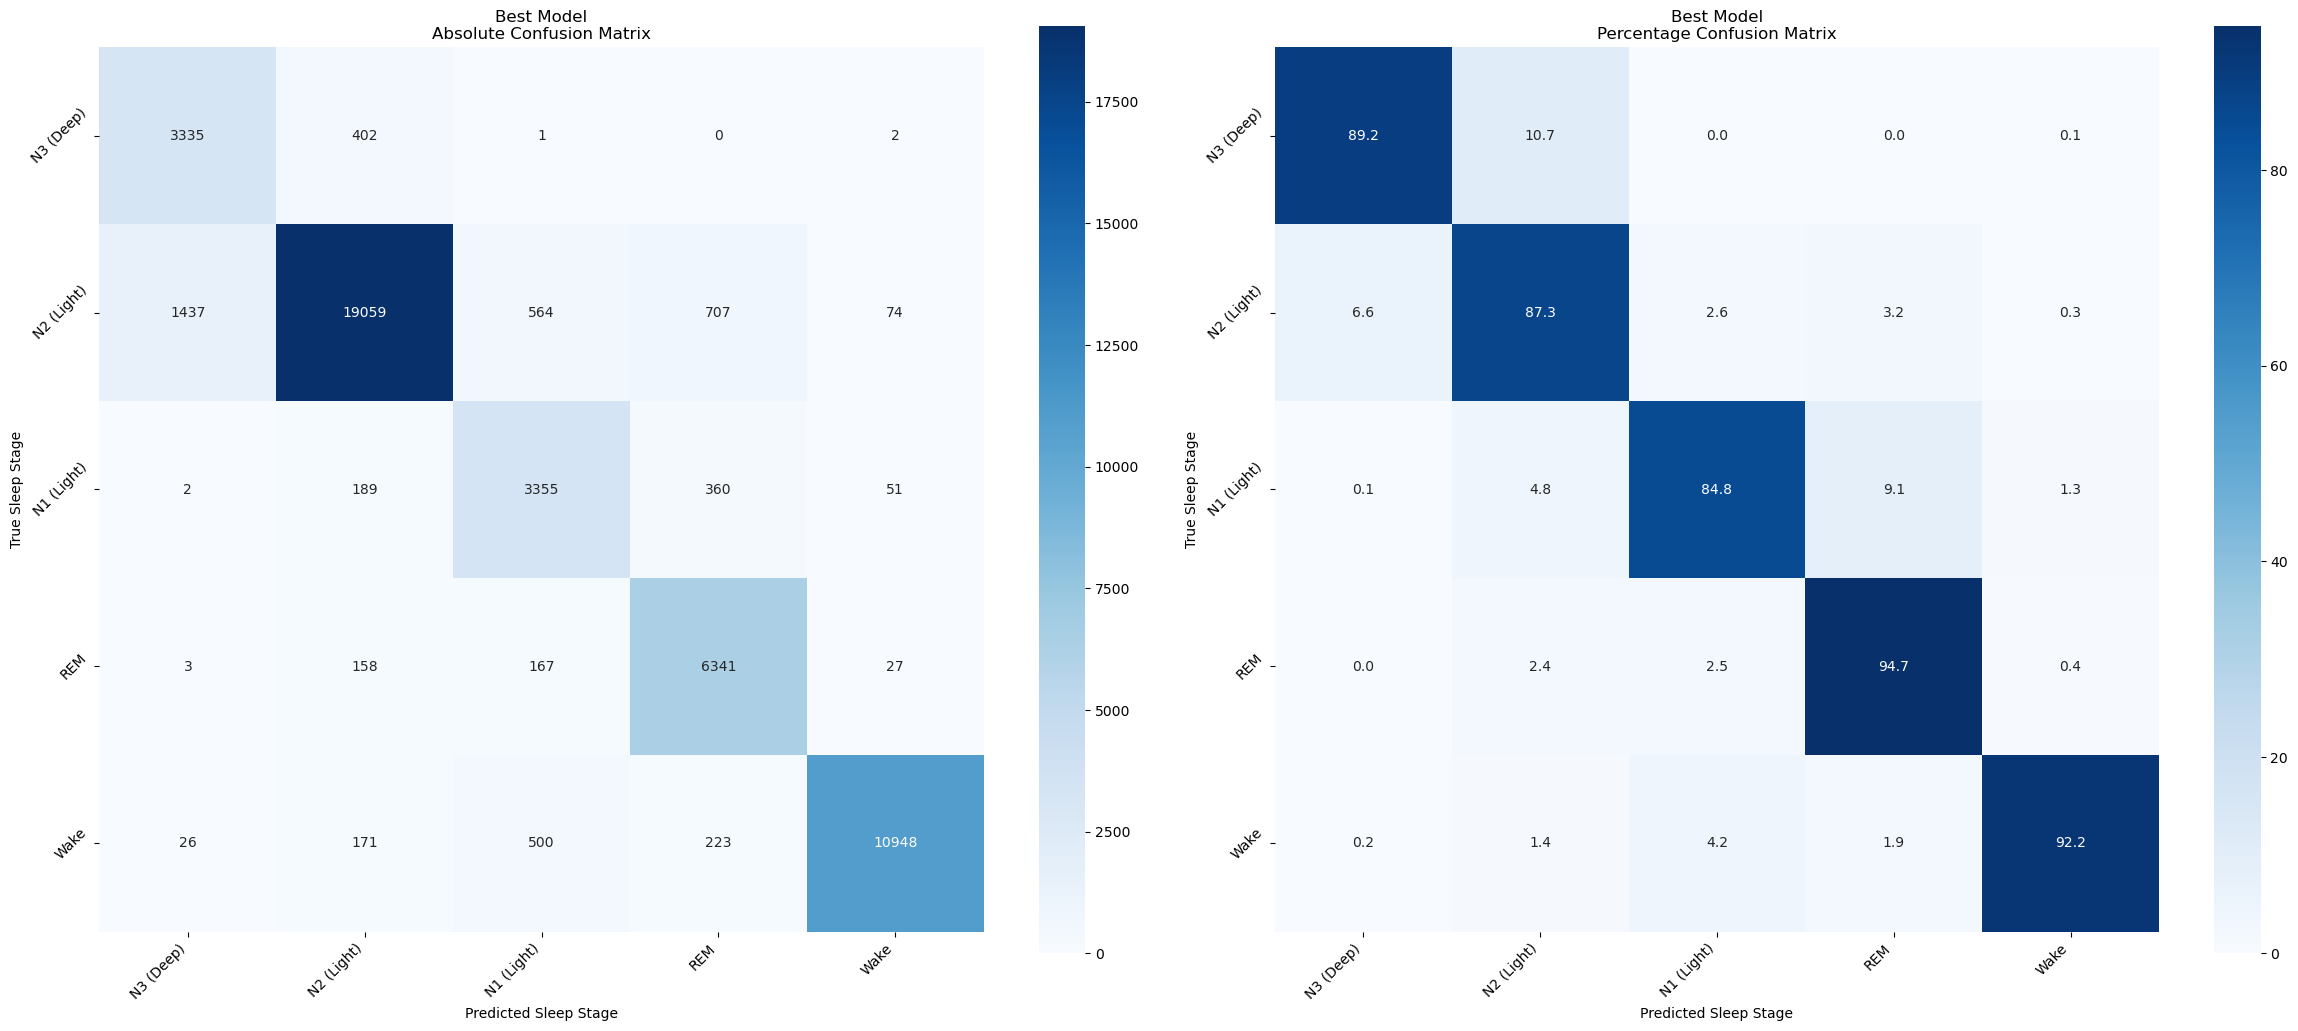


--------------------------------------------------
Best Model Results:
--------------------------------------------------
Overall Accuracy: 89.5%
Macro F1-Score: 86.3%
Weighted F1-Score: 89.8%


,N3 (Deep),N2 (Light),N1 (Light),REM,Wake,Macro Avg,Weighted Avg
Precision,69.4%,95.4%,73.1%,83.1%,98.6%,83.9%,90.6%
Recall,89.2%,87.3%,84.8%,94.7%,92.2%,89.6%,89.5%
F1-Score,78.1%,91.1%,78.5%,88.5%,95.3%,86.3%,89.8%
Support,374000,2184100,395700,669600,1186800,4810200,4810200


2024-11-03 10:36:18,583 - INFO - 
Best Model Performance:
2024-11-03 10:36:18,585 - INFO - Validation Metrics:
2024-11-03 10:36:18,601 - INFO -     Loss: 0.9281
2024-11-03 10:36:18,613 - INFO -     Accuracy: 0.8321
2024-11-03 10:36:18,629 - INFO -     F1 Macro: 0.7562
2024-11-03 10:36:18,652 - INFO -     F1 Weighted: 0.8349


In [50]:
# Save and log results
save_dir, best_model = save_best_model_results(
    results=results,
    data_manager=data_manager,
    model_params=model_params,
    train_params=train_params
)

In [56]:
logging.info(f"Class distribution:\n {format_class_distribution(Counter(data_manager.data['y'].numpy()))}")

2024-11-03 13:05:41,866 - INFO - Class distribution:
 N3 (Deep): 3740 (7.8%)
    N2 (Light): 21841 (45.4%)
    N1 (Light): 3957 (8.2%)
    REM: 6696 (13.9%)
    Wake: 11868 (24.7%)


In [ ]:
# def analyze_cross_validation_results(results):
#     """Analyze results across all folds"""
#     # Collect metrics across folds
#     fold_metrics = {
#         'f1_macro': [],
#         'accuracy': [],
#         'per_class_f1': [],
#         'confusion_matrices': []
#     }
    
#     for fold_result in results:
#         metrics = fold_result['metrics']
#         fold_metrics['f1_macro'].append(metrics['f1_macro'])
#         fold_metrics['accuracy'].append(metrics['accuracy'])
#         fold_metrics['per_class_f1'].append(metrics['per_class_f1'])
#         fold_metrics['confusion_matrices'].append(metrics['confusion_matrix'])
    
#     # Calculate mean and std
#     summary = {
#         'f1_macro_mean': np.mean(fold_metrics['f1_macro']),
#         'f1_macro_std': np.std(fold_metrics['f1_macro']),
#         'accuracy_mean': np.mean(fold_metrics['accuracy']),
#         'accuracy_std': np.std(fold_metrics['accuracy']),
#         'per_class_f1_mean': np.mean(fold_metrics['per_class_f1'], axis=0),
#         'per_class_f1_std': np.std(fold_metrics['per_class_f1'], axis=0),
#         'confusion_matrix_mean': np.mean(fold_metrics['confusion_matrices'], axis=0)
#     }
    
#     # Print summary
#     print("\nCross-validation Results:")
#     print(f"F1-Macro: {summary['f1_macro_mean']:.4f} ± {summary['f1_macro_std']:.4f}")
#     print(f"Accuracy: {summary['accuracy_mean']:.4f} ± {summary['accuracy_std']:.4f}")
    
#     print("\nPer-class F1 scores:")
#     for i in range(len(SLEEP_STAGES)):
#         mean = summary['per_class_f1_mean'][i]
#         std = summary['per_class_f1_std'][i]
#         print(f"{SLEEP_STAGES[i]}: {mean:.4f} ± {std:.4f}")
    
#     return summary

# # Usage:
# cv_summary = analyze_cross_validation_results(results)


Cross-validation Results:
F1-Macro: 0.7208 ± 0.0226
Accuracy: 0.7941 ± 0.0219

Per-class F1 scores:
N3 (Deep): 0.6959 ± 0.0694
N2 (Light): 0.8520 ± 0.0234
N1 (Light): 0.4250 ± 0.0107
REM: 0.7301 ± 0.0485
Wake: 0.9009 ± 0.0173


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os

# # Map class indices to sleep stage names
# class_mapping = {
#     0: 'N3 (Deep)',
#     1: 'N2 (Light)',
#     2: 'N1 (Light)',
#     3: 'REM',
#     4: 'Wake'
# }
# class_names = [class_mapping[i] for i in range(5)]
# save_outputs = False





# def create_fold_summary_table(model_dir, file_name='training_results.pt'):
#     """Create a summary table of metrics for each fold."""
    
#     # Initialize an empty DataFrame to store fold results
#     summary_df = pd.DataFrame(columns=['Fold', 'Accuracy', 'Macro F1', 'Weighted F1'] + class_names)
    
#     # Load the saved results from each fold
#     fold_results = torch.load(os.path.join(model_dir, file_name))
    
#     for fold_result in fold_results:
#         fold = fold_result['fold']
#         metrics = fold_result['metrics']
        
#         # Extract the metrics
#         accuracy = metrics['accuracy'] * 100
#         f1_macro = metrics['f1_macro'] * 100
#         f1_weighted = metrics['f1_weighted'] * 100
#         per_class_f1 = metrics['per_class_f1'] * 100  # Convert to percentage
        
#         # Create a dictionary for the current fold
#         fold_data = {
#             'Fold': fold,
#             'Accuracy': accuracy,
#             'Macro F1': f1_macro,
#             'Weighted F1': f1_weighted
#         }
        
#         # Add per-class F1 scores
#         for i, class_name in enumerate(class_names):
#             fold_data[class_name] = per_class_f1[i]
        
#         # Append the fold data to the summary DataFrame
#         summary_df = pd.concat([summary_df, pd.DataFrame(fold_data, index=[0])], ignore_index=True)
    
#     # Set the Fold column as the index
#     summary_df.set_index('Fold', inplace=True)
    
#     # Display the summary table with styling
#     styled_summary = summary_df.style\
#         .format(lambda x: f'{x:.1f}%' if pd.notnull(x) else '-', na_rep='-')\
#         .background_gradient(cmap='RdYlGn', subset=pd.IndexSlice[:, class_names + ['Accuracy', 'Macro F1', 'Weighted F1']])\
#         .set_caption("Summary of Metrics Across All Folds")
    
#     # Display the styled summary
#     display(styled_summary)
    
#     # Optionally save the summary table to a CSV file
#     if save_outputs:
#         os.makedirs(os.path.join(model_dir, 'test_results'), exist_ok=True)
#         summary_df.to_csv(os.path.join(model_dir, 'test_results', 'fold_summary_metrics.csv'))
    
#     return summary_df




In [ ]:

# model_dir = os.path.join(BASE_DIR, 'models', 'new7')


# # Generate the summary table for all folds
# summary_df = create_fold_summary_table(model_dir)

/tmp/ipykernel_3719951/107535558.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fold_results = torch.load(os.path.join(model_dir, file_name))
/tmp/ipykernel_3719951/10

,Accuracy,Macro F1,Weighted F1,N3 (Deep),N2 (Light),N1 (Light),REM,Wake
Fold,,,,,,,,
1,79.7%,73.0%,80.1%,76.8%,85.3%,40.7%,72.6%,89.9%
2,77.2%,71.1%,77.5%,73.8%,84.4%,43.5%,66.8%,87.2%
3,83.2%,75.6%,83.5%,74.9%,88.7%,42.2%,80.0%,92.3%
4,77.3%,68.8%,78.0%,59.8%,81.5%,42.4%,68.9%,91.3%
5,79.6%,71.8%,80.8%,62.7%,86.1%,43.7%,76.8%,89.8%
